# Practical 6: MRIO seminal works

#### Objectives
- Learn how to replicate the methods and results from a few studies. 
- Understand and explain main results from EEIOA studies using MRIO seminal works


### Exercise 1
Hertwich and Peters (2009) developed an analysis of the carbon footprint of multiple countries in 2001. Their results show the carbon footprint of different final demand categories per product.

In this exercise you will reproduce these results using EXIOBASE product by product Input-Output tables and compare any changes between 2001 and 2011

N.b. in this and future exercises we sometimes refer to general dataframes as df

<img src="figures/global_CO2_footprint.png" width="70%" />

Figure 1. Global CO2 footprint for different consumption categories and users retrieved from Hertwich and Peters (2009)

##### Steps in this exercise:
- Import data
- Calculate Leontief inverse and environmental intesity matrix
- Final demand contribution to environmental footprint

### Import modules and data

In [1]:
# Import modules
import pandas as pd 
import numpy as np

In [2]:
# Import exiobase
path = 'data/IOT_2001_pxp/'    # add name of folder where data is stored                                
A = pd.read_csv(f'{path}A.txt', sep='\t', index_col=[0, 1], header=[0, 1])  # A matrix
Y = pd.read_csv(f'{path}Y.txt', sep='\t', index_col=[0, 1], header=[0, 1])  # Y matrix
F = pd.read_csv(f'{path}satellite/F.txt', sep='\t', index_col=[0], header=[0, 1])  # satellite matrix
F_hh = pd.read_csv(f'{path}satellite/F_Y.txt', sep='\t', index_col=[0], header=[0, 1])  # satellite for FD matrix

### Calculate the Leontief inverse

In [3]:
# An identy matrix of the size as A-matrix
I = np.identity(A.shape[0]) 

## Leontief inverse matrix
L = np.linalg.inv(I - A) 

In [4]:
## Calculate total output vector (x)

y_total = Y.sum(1)      # Sum of all final demand categories
x = L @ y_total         # Total outputs

### Calculate environmental intensity matrix
From satellite matrix (F), select row for CO2 (i.e., F_co2). This can be done using df.loc

In [5]:
indicator = 'CO2 - combustion - air' # Label
F_ = F.loc[indicator, :]  # select CO2 vector

F_

region  sector                                           
AT      Paddy rice                                           0.000000e+00
        Wheat                                                1.911069e+08
        Cereal grains nec                                    2.500416e+08
        Vegetables, fruit, nuts                              1.467770e+08
        Oil seeds                                            2.142416e+07
                                                                 ...     
WM      Membership organisation services n.e.c. (91)         6.910619e+08
        Recreational, cultural and sporting services (92)    1.236598e+09
        Other services (93)                                  3.147455e+09
        Private households with employed persons (95)        1.097047e+08
        Extra-territorial organizations and bodies           0.000000e+00
Name: CO2 - combustion - air, Length: 9800, dtype: float64

In [6]:
F.index

Index(['Taxes less subsidies on products purchased: Total',
       'Other net taxes on production',
       'Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled',
       'Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled',
       'Compensation of employees; wages, salaries, & employers' social contributions: High-skilled',
       'Operating surplus: Consumption of fixed capital',
       'Operating surplus: Rents on land',
       'Operating surplus: Royalties on resources',
       'Operating surplus: Remaining net operating surplus',
       'Employment: Low-skilled male',
       ...
       'Water Withdrawal Blue - Domestic - domestic Water Withdrawal Blue',
       'Energy Carrier Net Total', 'Energy Carrier Net NENE',
       'Energy Carrier Net NTRA', 'Energy Carrier Net TAVI',
       'Energy Carrier Net TMAR', 'Energy Carrier Net TOTH',
       'Energy Carrier Net TRAI', 'Energy Carrier Net TROA',
       '

In [7]:
# we make a copy of our product output vector
x_inv = x.copy() 

# we divide 1 by the values that are non-0
x_inv[x_inv!=0] = 1/x_inv[x_inv!=0]


In [8]:
# We are essentially dividing the total extension by the product output
# This gives us coefficients of extension by unit of output (e.g., kg/euro)
f = F_ * x_inv

As mentioned in the previous lecture the other option you have is to divide the extension vector by the total product output and then replace inf and nan values by 0's.

In [9]:
f_ = F_/x.transpose() # co2 intensity vector
f_ = f_.replace([np.inf, -np.inf, np.nan], 0)  # replacing inf, -inf, and nan with zeros

### Contribution of Final Demand to the CO2 footprint
From the final demand matrix (Y), calculate the global final demand of households (y_hh), government expenditures (y_gov) and gross capital formation (y_cap).

In [10]:
## Calculation y_hh, y_gov, and y_cap
hh_lab = 'Final consumption expenditure by households' 
gov_lab = 'Final consumption expenditure by government'	
cap_lab = 'Gross fixed capital formation'

y_hh = Y.loc[ :, pd.IndexSlice[:, hh_lab]]  # selecting hh columns for all countries/regions
y_hh = y_hh.sum(1)  # global final expenditure by household

y_gov = Y.loc[ :, pd.IndexSlice[:, gov_lab]] # selecting gov columns for all countries/regions
y_gov = y_gov.sum(1)  # global final expenditure by government

y_cap = Y.loc[ :, pd.IndexSlice[:, cap_lab]] # selecting cap columns for all countries/regions
y_cap = y_cap.sum(1)  # global capital formation 

In the previous lectures you have used the method df.loc[pd.IndexSlice[level_0, level_1], :] to slice dataframes with multi-index labels

If you find it more practical you can also use the df.xs(label, axis, level, drop_level) method instead

- the first argument is the label you want to select
- the second argument axis is the axis (rows=0 or columns=1)
- the third agument is the level (e.g., level=0 is the region)
- the forth argument drop_level allows you to specify whether you want to keep the level of the multiindex you sliced or not


In [11]:
y_hh = Y.xs(hh_lab, axis=1, level=1, drop_level=False)  # selecting hh columns for all countries/regions
y_hh = y_hh.sum(1)  # global final expenditure by household

y_gov = Y.xs(gov_lab, axis=1, level=1, drop_level=False)  # selecting gov columns for all countries/regions
y_gov = y_gov.sum(1)  # global final expenditure by government

y_cap = Y.xs(cap_lab, axis=1, level=1, drop_level=False)  # selecting cap columns for all countries/regions
y_cap = y_cap.sum(1)  # global capital formation 

### Calculation CO2 footprint per final demand category per product

In [12]:
F_hh = f @ L @ np.diag(y_hh) # CO2 footprint by household expenditures
F_gov = f @ L @ np.diag(y_gov) # CO2 footprint by goverment expenditures 
F_cap = f @ L @ np.diag(y_cap) # CO2 footprint by capital formation 

In [13]:
F_cap.shape

(9800,)

At this point, it should be 3 vectors (for each final demand category from point 2) of 1 row with 9800 columns (i.e., 49 regions x 200 products)

Now reshape each vector using np.reshape so that you have 3 matrices with 49 rows (for each country/region) and 200 columns (for each product)

In [14]:
## Reshape vectors

F_hh = np.array(F_hh).reshape(49,200) # reshape to 49 countries/regions and 200 products
F_hh_sum = np.sum(F_hh, axis=0) # sum per product category

F_gov = np.array(F_gov).reshape(49,200) # reshape to 49 countries/regions and 200 products
F_gov_sum = np.sum(F_gov, axis=0) # sum per product category

F_cap = np.array(F_cap).reshape(49,200) # reshape to 49 countries/regions and 200 products
F_cap_sum = np.sum(F_cap, axis=0) # sum per product category

F_hh.shape

(49, 200)

In [15]:
## Build new pandas dataframe

results_by_Y_cat = pd.DataFrame([F_hh_sum, F_gov_sum, F_cap_sum])

results_by_Y_cat

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,7.868416e+09,3.157050e+10,2.771524e+10,2.163002e+11,5.824129e+09,1.139719e+06,1.539259e+09,4.272506e+10,3.153633e+08,5.821628e+06,...,8.098538e+09,6.169027e+09,7.092669e+09,2.649249e+09,3.256029e+09,3.468234e+10,1.270449e+11,1.342396e+11,3.801963e+10,0.0
1,4.487986e+08,1.451445e+09,4.054404e+08,8.699842e+08,4.478168e+08,4.162463e+08,1.067534e+08,1.784731e+08,3.509731e+08,7.076513e+08,...,2.132729e+09,1.216581e+09,1.829407e+09,5.855691e+08,7.640638e+08,1.318077e+10,2.423902e+10,3.642885e+09,1.409523e+09,0.0
2,3.124147e+05,4.398144e+08,2.315412e+08,8.449092e+08,3.296667e+05,0.000000e+00,2.491486e+04,9.694778e+08,8.864101e+09,8.004956e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.220207e+09,6.947273e+09,2.586570e+07,0.0


### Separate results by sectors

- Extraction
- Manufacturing
- Construction
- Services

In [16]:
### Index product categories

ext_ind = list(range(0,41)) # extraction categories (including agriculture, and mining)
man_ind = list(range(41,149)) # manufacturing (including food, clothing, other products)
con_ind = list(range(149,151)) # construction categories
ser_ind = list(range(151,200))  # services categories

## Sum per product group

ext = results_by_Y_cat.iloc[:, ext_ind].sum(1)
man = results_by_Y_cat.iloc[:, man_ind].sum(1)
con = results_by_Y_cat.iloc[:, con_ind].sum(1)
ser = results_by_Y_cat.iloc[:, ser_ind].sum(1)

In [17]:
## Re-group dataframe and add labels

results = pd.concat([ext, man, con, ser], axis=1)
results.index = ['Households', 'Goverment', 'Investment']
results.columns = ['Agriculture and Mining', 'Manufacturing', 'Construction', 'Services']
results

,Agriculture and Mining,Manufacturing,Construction,Services
Households,5.160513e+11,6.425162e+12,2.118665e+10,3.559804e+12
Goverment,9.290560e+09,1.312337e+11,2.282004e+10,1.772966e+12
Investment,1.843192e+11,1.976256e+12,2.376948e+12,2.672943e+11


### Visualize the results
Create a bar graph showing the final contribution per product category to the CO2 footprint

Note: This can be done by using:
results.plot.barh(stacked=True)

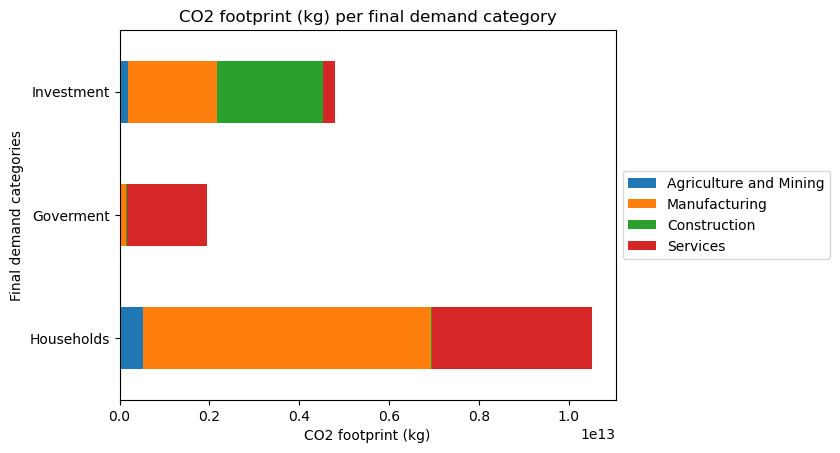

In [18]:
## Create a vertical bar chart

ef_name = 'CO2 footprint (kg)'
fig = results.plot.barh(stacked=True)
fig.set_xlabel("CO2 footprint (kg)")
fig.set_ylabel("Final demand categories")
fig.set_title(ef_name + " per final demand category")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Replicate these steps for 2011 data

## References
Hertwich, E. G., & Peters, G. P. (2009). Carbon footprint of nations: A global, trade-linked analysis. Environmental Science and Technology, 43(16), 6414–6420. https://doi.org/10.1021/es803496a

Wood, R., Stadler, K., Simas, M., Bulavskaya, T., Giljum, S., Lutter, S., & Tukker, A. (2018). Growth in Environmental Footprints and Environmental Impacts Embodied in Trade: Resource Efficiency Indicators from EXIOBASE3. Journal of Industrial Ecology, 22(3), 553–562. https://doi.org/10.1111/jiec.12735